In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Nahuel Elias\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
homicidios = pd.read_excel('homicidios.xlsx') # se refiere a la hoja hechos del xls homicidios
homicidios_victimas= pd.read_excel('homicidios.xlsx', sheet_name=2) # se refiere a la hoja victimas del xls homicidios
homicidios.to_pickle('homicidios.pkl')
homicidios_victimas.to_pickle('homicidios_victimas.pkl')

In [3]:
homicidios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     696 non-null    object        
 1   N_VICTIMAS             696 non-null    int64         
 2   FECHA                  696 non-null    datetime64[ns]
 3   AAAA                   696 non-null    int64         
 4   MM                     696 non-null    int64         
 5   DD                     696 non-null    int64         
 6   HORA                   696 non-null    object        
 7   HH                     696 non-null    object        
 8   LUGAR_DEL_HECHO        696 non-null    object        
 9   TIPO_DE_CALLE          696 non-null    object        
 10  Calle                  695 non-null    object        
 11  Altura                 129 non-null    float64       
 12  Cruce                  525 non-null    object        
 13  Direc

### Los datos analizados van desde el 1 de enero del 2016 al 31 de diciembre del 2021

In [4]:
print('Los datos analizados van desde: ', homicidios.FECHA.min(), 'hasta: ', homicidios.FECHA.max())

Los datos analizados van desde:  2016-01-01 00:00:00 hasta:  2021-12-30 00:00:00


In [4]:
print('Cantidad de registros de ID sin repetir: ', homicidios['ID'].unique().size, ', cantidad de registros totales: ', len(homicidios))

Cantidad de registros de ID sin repetir:  696 , cantidad de registros totales:  696


No hay valores repetidos para ID

### Aumento de la población:

Según el instituto nacional de Censos y Estadisticas de la Republica Argentina (INDEC), la población del distrito Ciudad Autonoma de Buenos Aires del censo del 2010 fue de 2890151 y en el 2022 3120612. Hay un aumento en el período del 8 %

In [7]:
pob_2022 = 3120612
pob_2010 = 2890151
aumento = pob_2022-pob_2010
aumentop = aumento/pob_2010*100
print('Aumento de la poblacion entre censos 2010 y 2022 en %: ', aumentop)


Aumento de la poblacion entre censos 2010 y 2022 en %:  7.974012430492386


Para que sea mas real el ratio accidentes cada 100000 habitantes se construye una recta de interpolacion para poder calcular la poblacion en los años dados.

In [8]:
m=round(aumento/(2022-2010), 4)
ord_al_origen1 = pob_2022-m*2022

print('Ordenada al origen: ', ord_al_origen1, 'pendiene: ', m)
# valores para recta de interpolacion: ord_al_origen

Ordenada al origen:  -35712066.4326 pendiene:  19205.0833


## Transformacion del dataframe homicidios:

In [140]:
#Se Crea una columna con la poblacion de la Ciudad Autonoma de Buenos Aires. La estimacion es realizada interpolando los valores de poblacion entre el censo 2010 y 2022
# y es funcion de la columna AAAA
homicidios = pd.read_pickle('homicidios.pkl')
homicidios.insert(2, column='Poblacion_CABA', value=ord_al_origen1+m*homicidios['AAAA'])
homicidios['ID'] = homicidios['ID'].astype(str)
homicidios['HH'] = homicidios['HH'].replace('SD', 0).astype(int)
homicidios.insert(5, column='dia', value='a') 
homicidios.dia = homicidios.FECHA.dt.day_name(locale= 'es_ES.utf8')
homicidios.dia = homicidios.dia.replace('Sã¡bado', 'Sabado')
homicidios.dia = homicidios.dia.replace('Miã©rcoles', 'Miercoles')
homicidios['TIPO_DE_CALLE'] = homicidios['TIPO_DE_CALLE'].replace(to_replace='GRAL PAZ', value='AUTOPISTA')

In [17]:
#homicidios.info()

### Número de victimas por accidente:

In [19]:
N_victimas= homicidios['N_VICTIMAS'].value_counts().reset_index()
N_victimas.rename(columns={'index':'Victimas por accidente', 'N_VICTIMAS': 'Cantidad de accidentes'}, inplace=True)
N_victimas

,Victimas por accidente,Cantidad de accidentes
0,1,676
1,2,19
2,3,1


En la mayoria de los accidentes hubo solo una victima fatal. Solo hubo un accidente que la cantidad de victimas fue 3

### Cantidad de accidentes por dia de la semana

In [21]:
dia= homicidios['dia'].value_counts().reset_index()
dia

,index,dia
0,Lunes,106
1,Sabado,103
2,Domingo,99
3,Martes,99
4,Miercoles,98
5,Viernes,97
6,Jueves,94


Text(0.5, 1.0, 'Número de muertos por Día (del 01-01-2016 al 31-12-2021)')

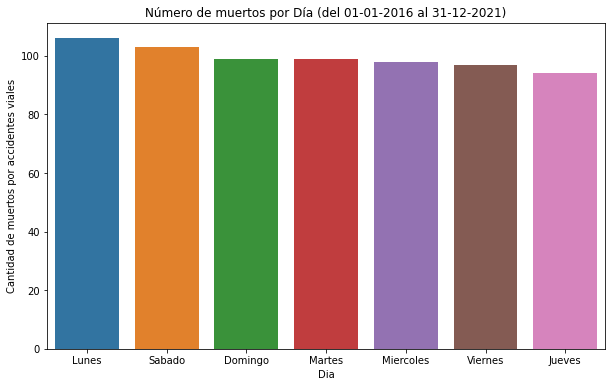

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(x='dia', data=homicidios, order=homicidios['dia'].value_counts().index)
plt.xlabel("Dia")
plt.ylabel("Cantidad de muertos por accidentes viales")
plt.title("Número de muertos por Día (del 01-01-2016 al 31-12-2021)")

Si bien el dia lunes es el dia con mayor accidentes y el jueves con menor, no hay una tendencia clara debido a que la diferencia entre valores es baja. 

### Accidentes por mes

In [23]:

homicidios.nunique(axis=0, dropna=True) # observando la fila MM puede verse que se produjeron accidentes mortales durante todos los meses.
mes= homicidios['MM'].value_counts().reset_index()
mes.columns = ['mes', 'cantidad']
mes

,mes,cantidad
0,12,78
1,11,67
2,8,65
3,1,62
4,5,60
5,6,58
6,2,56
7,3,51
8,7,51
9,10,51


Text(0.5, 1.0, 'Número de muertos por meses (del 01-01-2016 al 31-12-2021)')

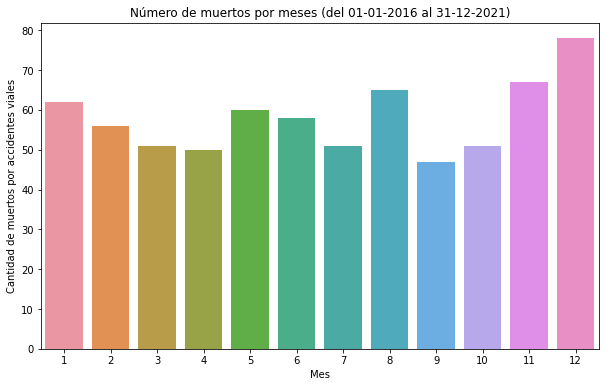

In [24]:
plt.figure(figsize=(10, 6))
sns.countplot(x='MM', data=homicidios)
plt.xlabel("Mes")
plt.ylabel("Cantidad de muertos por accidentes viales")
plt.title("Número de muertos por meses (del 01-01-2016 al 31-12-2021)")

### Víctimas fatales por año

In [25]:
Anio = homicidios['AAAA'].value_counts().reset_index()
Anio.columns = ['Anio', 'Cantidad']
Anio

,Anio,Cantidad
0,2016,144
1,2018,143
2,2017,131
3,2019,103
4,2021,97
5,2020,78


In [27]:
Anioc100= homicidios['AAAA'].value_counts().reset_index()
Anioc100.columns = ['Anio', 'Cantidad']
Anioc100.insert(2, 'victimas/100k', value=Anio['Cantidad']/(ord_al_origen1+m*Anioc100['Anio'])*100000) #Para estimar la poblacion por año se utiliza
                                                                                                        #la formula de la interpolacion lineal calculada al principio
Anioc100

,Anio,Cantidad,victimas/100k
0,2016,144,4.791405
1,2018,143,4.698088
2,2017,131,4.331170
3,2019,103,3.362720
4,2021,97,3.127613
5,2020,78,2.530658


Text(0.5, 1.0, 'Victimas por año cada 100000 habitantes')

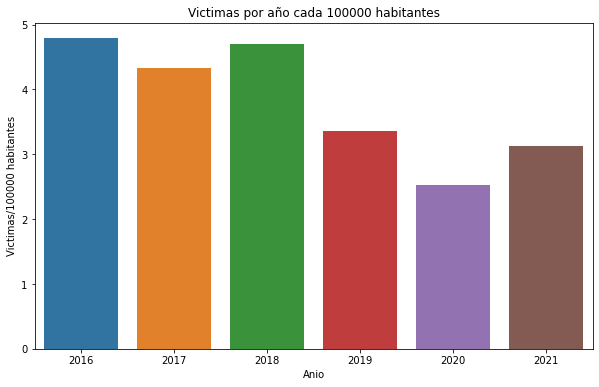

In [28]:
plt.figure(figsize=(10, 6))
sns.barplot(x = "Anio", y = "victimas/100k", data = Anioc100)
plt.xlabel("Anio")
plt.ylabel("Victimas/100000 habitantes")
plt.title("Victimas por año cada 100000 habitantes")

En el gráfico puede verse una disminucion de los accidentes cada 100000 habitantes a lo largo de los años. Observar la baja del año 2020 debida a la disminucion de transito por el aislamiento social preventivo por la pandemia de Covid.

Tener en cuenta que la poblacion año a año es estimada por interpolación lineal entre los datos de los censos de 2010 y 2022.

### Víctimas por hora del dia

In [30]:
hora = homicidios['HH'].value_counts().reset_index()
hora.columns = ['hora', 'cantidad']
#hora

Text(0.5, 1.0, 'Víctimas por hora del dia')

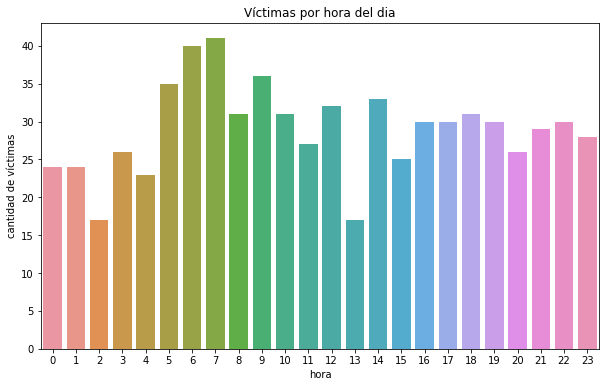

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(x = "hora", y = "cantidad", data = hora)
plt.xlabel("hora")
plt.ylabel("cantidad de víctimas")
plt.title("Víctimas por hora del dia")

Puede verse un aumento de accidentes en hora pico de la mañana (de 6 a 9). En hora pico de la tarde (16 a 20) hay otro pico aunque no parece verse un aumento tan significativo. 

Tener en cuenta que habia dos registros en la columna HH que tenian de valor 'SD'. Esos valores fueron remplazados por 0

La columna 'LUGAR_DEL_HECHO', da la dirección del accidente. Para analizar se me ocurrio separar las dos calles (en caso de que sea una esquina) en dos columnas. Esas dos columnas serán 'calle_1' y 'calle_2'. En el caso de que solo contenga una sola calle (un caso seria que el accidente se produjo a mitad de cuadra, es decir no necesariamente en un esquina), la columna calle 2 tendra NaN.

In [231]:
#se generan en el dataframe homicidios, las columnas calle_1 y calle_2 a partir de splitear la columna 'LUGAR_DEL_HECHO'.
I = homicidios['LUGAR_DEL_HECHO'].str.split(re.compile(r' Y ', re.IGNORECASE) , expand=True)
I[2].loc[I[2].isna()]=''
I['calle_2'] = I[1].str.cat(I[2], sep = ' ')
I['calle_2'] = I['calle_2'].str.strip()
I.rename(columns={0:'calle_1'}, inplace=True)
I.drop(columns= [1,2], inplace=True)
homicidios = pd.concat([homicidios, I], axis=1)


In [250]:
#valores_no_nulos = homicidios['calle_2'].notna()

# Crear un nuevo DataFrame con los valores no nulos
#df_filtrado = homicidios[valores_no_nulos]
#homicidios[homicidios['calle_2'].notna()]['calle_2'].count() #523
#homicidios[homicidios['calle_2'].isna()]['calle_2'].count()
#len(homicidios['calle_2'])
porcentaje_choques_esquinas= homicidios[homicidios['calle_2'].notna()]['calle_2'].count()/len(homicidios['calle_2']) *100
porcentaje_choques_esquinas

75.14367816091954

El porcenjate de choques en esquinas es de 75 %

### Cantidad de víctimas por tipo de vía.

In [293]:
homicidios.nunique(axis=0, dropna=True) # hay 4 tipos de calles
tipos_de_calle= homicidios['TIPO_DE_CALLE'].value_counts().reset_index()
tipos_de_calle.columns = ['tipo_de_calle', 'cantidad']

In [294]:
tipos_de_calle

,tipo_de_calle,cantidad
0,AVENIDA,429
1,CALLE,136
2,AUTOPISTA,66
3,GRAL PAZ,65


Observar que General Paz figura como un tipo de calle, siendo que General Paz es una autopista. Remplazaré General Paz por 'Autopista'

In [34]:
homicidios['TIPO_DE_CALLE'] = homicidios['TIPO_DE_CALLE'].replace(to_replace='GRAL PAZ', value='AUTOPISTA')
#homicidios['TIPO_DE_CALLE'].loc[homicidios['TIPO_DE_CALLE']=='GRAL PAZ'].
homicidios.nunique(axis=0, dropna=True) # hay 4 tipos de calles
tipos_de_calle= homicidios['TIPO_DE_CALLE'].value_counts().reset_index()
tipos_de_calle.columns = ['tipo_de_calle', 'cantidad']

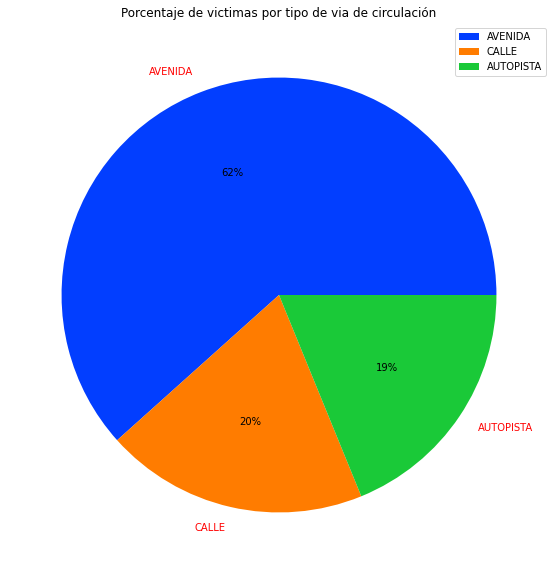

In [50]:
data = tipos_de_calle['cantidad']
labels = tipos_de_calle['tipo_de_calle']
colors = sns.color_palette('bright')
plt.figure(figsize=(10, 10))
# Crear el gráfico de torta
pie = plt.pie(data, labels=labels, colors=colors, autopct='%0.0f%%')
plt.gca().set_facecolor('black')  # Establecer el fondo negro

# Cambiar el color de las etiquetas a blanco
for label in pie[1]:
    label.set_color('red')
plt.legend()
plt.title("Porcentaje de victimas por tipo de via de circulación")
plt.show()

El tipo de via en el que menos accidentes mortales se producen es la autopista.

### Siniestros en esquinas?

De acuerdo a las definiciones del diccionario, en caso de que el siniestro se haya producido en una esquina, entonces en la columna 'Cruce' deberia verse el nombre de la calle. Puede deducirse entonces que si el registro en esa columna esta en NaN, el siniestro no se produjo entonces en una esquina.


In [62]:
#homicidios.info()
#homicidios[['Calle', 'Altura', 'Cruce']].sample(30)
porcentaje_choques_esquinas = homicidios[homicidios['Cruce'].notna()]['Cruce'].count()/len(homicidios['Cruce']) *100
porcentaje_choques_esquinas

75.43103448275862

El 75 % de los siniestros en los que se hubo muertes, se produjeron en esquinas.

### Cantidad de accidentes por comuna

Para mas informacion sobre comunas de Ciudad de Buenos Aires: https://buenosaires.gob.ar/comunas

In [73]:
comunas= homicidios['COMUNA'].value_counts().reset_index()
comunas.columns = ['comuna', 'cantidad']
comunas = comunas.drop(index=15) # se dropea el index=15 que corresponde a la comuna 0. Esa comuna no existe y ese registro se trata de un error. Para este analisis no es tenido en cuenta ese registro.
comunas

,comuna,cantidad
0,1,90
1,4,76
2,9,73
3,8,65
4,7,60
5,3,45
6,15,44
7,13,40
8,12,37
9,14,35


Text(0.5, 1.0, 'Víctimas por comunas')

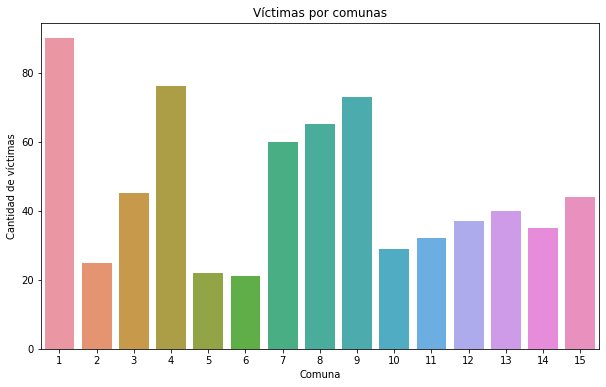

In [74]:
plt.figure(figsize=(10, 6))
sns.barplot(x = "comuna", y = "cantidad", data = comunas)
plt.xlabel("Comuna")
plt.ylabel("Cantidad de víctimas")
plt.title("Víctimas por comunas")

### Participantes en siniestros

In [80]:

participantes = homicidios['PARTICIPANTES'].value_counts().reset_index()
participantes.columns = ['participantes', 'cantidad']
participantes = participantes.iloc[0:14,:] # dado que son muchas convinaciones posibles, se trunca en los primeros 15
participantes

,participantes,cantidad
0,PEATON-PASAJEROS,105
1,MOTO-AUTO,83
2,MOTO-CARGAS,78
3,PEATON-AUTO,77
4,MOTO-PASAJEROS,46
5,MOTO-OBJETO FIJO,40
6,PEATON-CARGAS,38
7,AUTO-AUTO,31
8,PEATON-MOTO,30
9,MOTO-MOTO,25


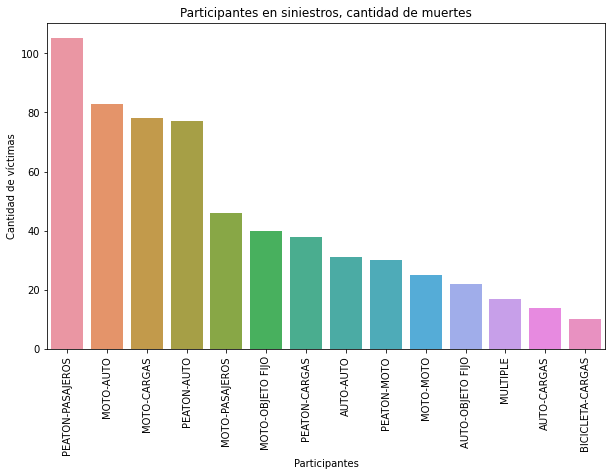

In [90]:
plt.figure(figsize=(10, 6))
sns.barplot(x = "participantes", y = "cantidad", data = participantes)
plt.xlabel("Participantes")
plt.ylabel("Cantidad de víctimas")
plt.title("Participantes en siniestros, cantidad de muertes")
plt.xticks(rotation=90);

### Victimas del siniestro

In [93]:
victimas = homicidios['VICTIMA'].value_counts().reset_index()
victimas.columns = ['victimas', 'cantidad']

victimas

,victimas,cantidad
0,MOTO,295
1,PEATON,264
2,AUTO,83
3,BICICLETA,29
4,SD,9
5,CARGAS,7
6,PASAJEROS,5
7,MOVIL,2
8,OBJETO FIJO,1
9,PEATON_MOTO,1


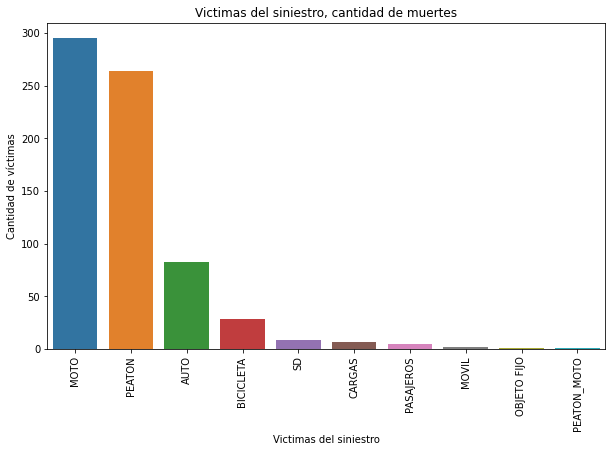

In [91]:
plt.figure(figsize=(10, 6))
sns.barplot(x = "victimas", y = "cantidad", data = victimas)
plt.xlabel("Victimas del siniestro")
plt.ylabel("Cantidad de víctimas")
plt.title("Victimas del siniestro, cantidad de muertes")
plt.xticks(rotation=90);

La mayoria de las personas muertas en accidentes de transito son motociclistas y peatones

In [94]:
acusados = homicidios['ACUSADO'].value_counts().reset_index()
acusados.columns = ['acusado', 'cantidad']
acusados

,acusado,cantidad
0,AUTO,204
1,PASAJEROS,173
2,CARGAS,146
3,OBJETO FIJO,62
4,MOTO,57
5,SD,23
6,MULTIPLE,17
7,BICICLETA,7
8,OTRO,6
9,TREN,1


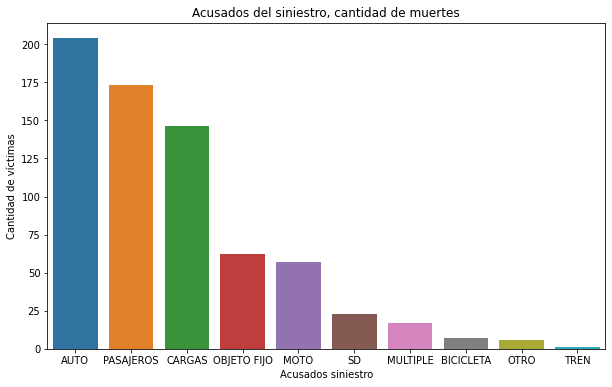

In [96]:
plt.figure(figsize=(10, 6))
sns.barplot(x = "acusado", y = "cantidad", data = acusados)
plt.xlabel("Acusados siniestro")
plt.ylabel("Cantidad de víctimas")
plt.title("Acusados del siniestro, cantidad de muertes");
#plt.xticks(rotation=90);

La mayoria de las muertes son causadas por autos, luego vehiculos de pasajeros y vehivulos de carga.

## Analisis del Dataframe homicidios_victimas

In [102]:
print('Cantidad de registros de ID sin repetir: ', homicidios_victimas['ID_hecho'].unique().size, ', cantidad de registros totales: ', len(homicidios_victimas))

Cantidad de registros de ID sin repetir:  696 , cantidad de registros totales:  717


Pueden verse repetidos en los ID_hecho y eso es debido a que puede que en un solo hecho haya habido mas de una víctima.

In [105]:
homicidios_victimas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_hecho             717 non-null    object        
 1   FECHA                717 non-null    datetime64[ns]
 2   AAAA                 717 non-null    int64         
 3   MM                   717 non-null    int64         
 4   DD                   717 non-null    int64         
 5   ROL                  717 non-null    object        
 6   VICTIMA              717 non-null    object        
 7   SEXO                 717 non-null    object        
 8   EDAD                 717 non-null    object        
 9   FECHA_FALLECIMIENTO  717 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 56.1+ KB


In [106]:
print('Los datos del dataframe homicidios_victimas  van desde: ', homicidios_victimas.FECHA.min(), 'hasta: ', homicidios_victimas.FECHA.max())

Los datos del dataframe homicidios_victimas  van desde:  2016-01-01 00:00:00 hasta:  2021-12-30 00:00:00


In [112]:
print('desde: ', min(homicidios_victimas['AAAA']), 'hasta: ', max(homicidios_victimas['AAAA']))

desde:  2016 hasta:  2021


In [115]:
print('mes min: ', min(homicidios_victimas['MM']), 'mes max: ', max(homicidios_victimas['MM']), 'dia min: ', min(homicidios_victimas['DD']), 'max dia: ', max(homicidios_victimas['DD']))

mes min:  1 mes max:  12 dia min:  1 max dia:  31


### Rol de las víctimas en el siniestro

In [117]:
rol = homicidios_victimas['ROL'].value_counts().reset_index()
rol.columns = ['rol', 'cantidad']
rol

,rol,cantidad
0,CONDUCTOR,330
1,PEATON,267
2,PASAJERO_ACOMPAÑANTE,80
3,CICLISTA,29
4,SD,11


In [122]:
print('La cantidad de victimas conductores que conducian una moto es : ', homicidios_victimas.loc[(homicidios_victimas['ROL']=='CONDUCTOR') & (homicidios_victimas['VICTIMA']=='MOTO')].count()[0])

La cantidad de victimas conductores que conducian una moto es :  261


De los 330 muertos conductores, la mayoría (261/330) conducían motos, con lo cual se verifica lo comentado en el otro dataframe en la columna Victima del siniestro.

In [124]:
rol = homicidios_victimas['SEXO'].value_counts().reset_index()
rol.columns = ['sexo', 'cantidad']
rol

,sexo,cantidad
0,MASCULINO,545
1,FEMENINO,166
2,SD,6


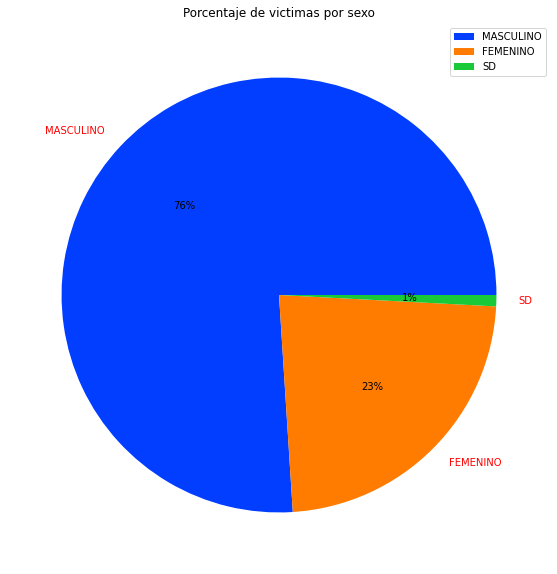

In [125]:
data = rol['cantidad']
labels = rol['sexo']
colors = sns.color_palette('bright')
plt.figure(figsize=(10, 10))
# Crear el gráfico de torta
pie = plt.pie(data, labels=labels, colors=colors, autopct='%0.0f%%')
plt.gca().set_facecolor('black')  # Establecer el fondo negro

# Cambiar el color de las etiquetas a blanco
for label in pie[1]:
    label.set_color('red')
plt.legend()
plt.title("Porcentaje de victimas por sexo")
plt.show()

In [24]:
#res = homicidios_victimas[['ROL', 'VICTIMA', 'SEXO', 'EDAD']]

## Transformaciones

In [27]:
homicidios_victimas = pd.read_pickle('homicidios_victimas.pkl')
# se pasan a int los valores de la columna edad. Los valores 'SD' se remplazan por 0 para poder tratar con enteros. son 53 personas aproximadamente.
homicidios_victimas['EDAD'] = homicidios_victimas['EDAD'].replace('SD', 0).astype(int) 


#Se genera una nueva columna con el rango etario. para la eleccion de los rangos se consira esto: https://economipedia.com/definiciones/segmentacion-por-edad.html 
# y ademas que en argentinapara poder sacar registro de conduccion de moto es necesario tener mas de 16 años.
bins = [0, 16, 27, 40, 60, 80, 120]  # Límites de los intervalos
etiquetas = ['menor de 16', 'entre 16 y 27', 'entre 27 y 40', 'entre 40 y 60', 'entre 60 y 75', 'mayor de 75']  # Etiquetas para cada intervalo


homicidios_victimas.insert(9,column='rango_etario', value='a')
homicidios_victimas['rango_etario'] = pd.cut(homicidios_victimas['EDAD'], bins=bins, labels=etiquetas, right=True, ordered=False)

In [146]:
homicidios_victimas['EDAD'].loc[homicidios_victimas['EDAD']==0].count()

53

In [145]:
homicidios_victimas['EDAD'].describe()

count    717.000000
mean      39.050209
std       22.010669
min        0.000000
25%       24.000000
50%       35.000000
75%       55.000000
max       95.000000
Name: EDAD, dtype: float64

In [11]:
homicidios_victimas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_hecho             717 non-null    object        
 1   FECHA                717 non-null    datetime64[ns]
 2   AAAA                 717 non-null    int64         
 3   MM                   717 non-null    int64         
 4   DD                   717 non-null    int64         
 5   ROL                  717 non-null    object        
 6   VICTIMA              717 non-null    object        
 7   SEXO                 717 non-null    object        
 8   EDAD                 717 non-null    int32         
 9   FECHA_FALLECIMIENTO  717 non-null    object        
dtypes: datetime64[ns](1), int32(1), int64(3), object(5)
memory usage: 53.3+ KB


In [28]:
rango_etario = homicidios_victimas['rango_etario'].value_counts().reset_index()
rango_etario.columns = ['rango_etario', 'cantidad']
rango_etario

,rango_etario,cantidad
0,entre 27 y 40,201
1,entre 40 y 60,162
2,entre 16 y 27,159
3,entre 60 y 75,94
4,mayor de 75,30
5,menor de 16,18


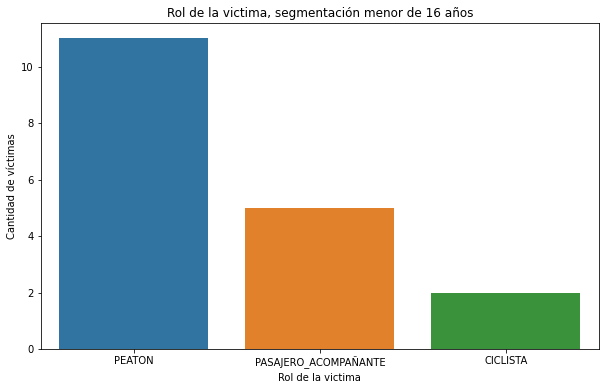

In [44]:
rango0 = homicidios_victimas.loc[(homicidios_victimas['rango_etario']== 'menor de 16')]
rol0 = rango0['ROL'].value_counts().reset_index()
rol0.columns = ['rol', 'cantidad']
plt.figure(figsize=(10, 6))
sns.barplot(x = "rol", y = "cantidad", data = rol0)
plt.xlabel("Rol de la victima")
plt.ylabel("Cantidad de víctimas")
plt.title("Rol de la victima, segmentación menor de 16 años");
##
rango1 = homicidios_victimas.loc[(homicidios_victimas['rango_etario']== 'entre 16 y 27')]
rol1 = rango1['ROL'].value_counts().reset_index()
rol0.columns = ['rol', 'cantidad']
plt.figure(figsize=(10, 6))
sns.barplot(x = "rol", y = "cantidad", data = rol0)
plt.xlabel("Rol de la victima")
plt.ylabel("Cantidad de víctimas")
plt.title("Rol de la victima, segmentación menor de 16 años");

#rango1 = homicidios_victimas.loc[(homicidios_victimas['rango_etario']== 'entre 16 y 27')]
#rango[2] = homicidios_victimas.loc[(homicidios_victimas['rango_etario']== 'entre 27 y 40')]
#rango[3]= homicidios_victimas.loc[(homicidios_victimas['rango_etario']== 'entre 40 y 60')]
#rango[4]= homicidios_victimas.loc[(homicidios_victimas['rango_etario']== 'entre 60 y 75')]
#rango[5] = homicidios_victimas.loc[(homicidios_victimas['rango_etario']== 'mayor de 75')]


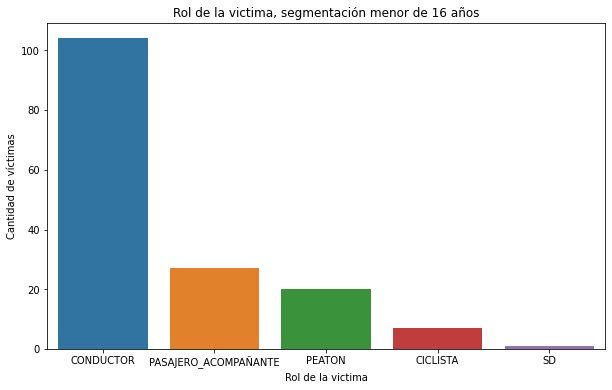

In [48]:
rango1 = homicidios_victimas.loc[(homicidios_victimas['rango_etario']== 'entre 16 y 27')]
rol1 = rango1['ROL'].value_counts().reset_index()
rol1.columns = ['rol', 'cantidad']
plt.figure(figsize=(10, 6))
sns.barplot(x = "rol", y = "cantidad", data = rol1)
plt.xlabel("Rol de la victima")
plt.ylabel("Cantidad de víctimas")
plt.title("Rol de la victima, segmentación menor de 16 años");

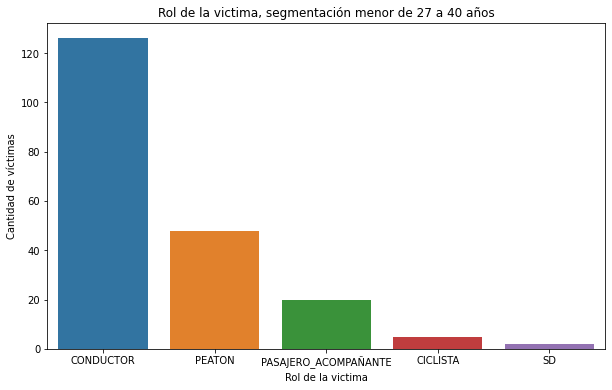

In [49]:
rango2 = homicidios_victimas.loc[(homicidios_victimas['rango_etario']== 'entre 27 y 40')]
rol2 = rango2['ROL'].value_counts().reset_index()
rol2.columns = ['rol', 'cantidad']
plt.figure(figsize=(10, 6))
sns.barplot(x = "rol", y = "cantidad", data = rol2)
plt.xlabel("Rol de la victima")
plt.ylabel("Cantidad de víctimas")
plt.title("Rol de la victima, segmentación menor de 27 a 40 años");

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x = "rol", y = "cantidad", data = rol)
plt.xlabel("Acusados siniestro")
plt.ylabel("Cantidad de víctimas")
plt.title("Acusados del siniestro, cantidad de muertes");


In [36]:
sns.barplot(x = homicidios_victimas['ROL'], y = len(homicidios_victimas.loc[(homicidios_victimas['rango_etario']== 'entre 16 y 27')]))
plt.xlabel("Acusados siniestro")
plt.ylabel("Cantidad de víctimas")
plt.title("Acusados del siniestro, cantidad de muertes");
#plt.xticks(rotation=90);

AttributeError: 'bool' object has no attribute 'all'

<AxesSubplot:xlabel='EDAD', ylabel='Count'>

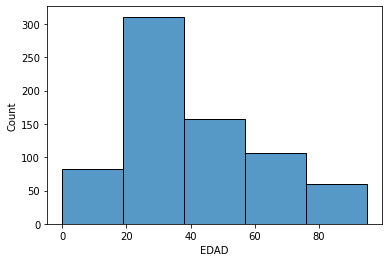

In [10]:
fig, axs = plt.subplots(5,1, figsize=(5,10))
#plt.hist(df['price'], bins=100)
axs[0].set_title('BTC')
axs[0].hist(layer_1_ohlc['Max_Variation_Normalized_bitcoin'].loc[layer_1_ohlc['Max_Variation_Normalized_bitcoin']<tope] , bins=bins, color='b')
axs[1].set_title('ETH')
axs[1].hist(layer_1_ohlc['Max_Variation_Normalized_ethereum'].loc[layer_1_ohlc['Max_Variation_Normalized_ethereum']<tope], bins=bins)
axs[2].set_title('BNB')
axs[2].hist(layer_1_ohlc['Max_Variation_Normalized_binancecoin'].loc[layer_1_ohlc['Max_Variation_Normalized_binancecoin']<tope], bins=bins)
axs[3].set_title('SOL')
axs[3].hist(layer_1_ohlc['Max_Variation_Normalized_solana'].loc[layer_1_ohlc['Max_Variation_Normalized_solana']<tope], bins=bins)
axs[4].set_title('DOGE')
axs[4].hist(layer_1_ohlc['Max_Variation_Normalized_dogecoin'].loc[layer_1_ohlc['Max_Variation_Normalized_dogecoin']<tope], bins=bins)

